# AlgTest Process TPM 2.0 data visualisation

This is a test for visualisation of html outputs in jupyter notebooks

## 1. Results
First we need to get TPM 2.0 results. Upload a folder with results in the left corner. Make sure your results are zipped and zip has following file structure. Following structure shows possible dir structures of the zip file:

```
tpmalgtest_results - This folder must be created when extracting
│
│
└───<tpm name>
│   │───detail
│   │   │─── docker_info.csv
│   │   │─── Keygen[_:]RSA_(1024|2048).csv - Important
│   │   │─── keygen_*.csv
│   │   └─── Quicktest_*.csv
│   │───performance
│   │   └─── <tpm name>.csv -> Performance result - Important
│   └───results
│       └─── <tpm name>.csv -> Support result - Important
│─── ...
│
│───<tpm name>
│   └───out
│       └───detail
│       │    │─── docker_info.csv
│       │    │─── Keygen_*.csv
│       │    │─── keygen_*.csv
│       │    └─── Quicktest_*.csv
│       │───performance
│       │   └─── <tpm name>.csv -> Performance result - Important
│       └───results
│           └─── <tpm name>.csv -> Support result - Important
│─── ...
│   
└───out.*
│   │─── docker_info.csv
│   │─── Keygen_*.csv
│   │─── keygen_*.csv
│   └─── Quicktest_*.csv
└─── ...
```

### a) Unzipping

In [1]:
import zipfile
# Fill in the filename
FILENAME = "tpmalgtest_results.zip"

with zipfile.ZipFile(FILENAME,"r") as zip_ref:
    zip_ref.extractall(".")

### b) Parsing results

In [362]:
import pandas as pd
from algtestprocess.modules.parser.tpm.performance import PerformanceParserTPM
from algtestprocess.modules.parser.tpm.support import SupportParserTPM

def get_tpm_profiles():
    # First we get all the files in the dir
    files =[os.path.join(root, file) for root, dirs, files in os.walk("./tpmalgtest_results") for file in files]
    # Then we filter performance and support result .csv files
    performance = list(filter(lambda name: "/performance/" in name and ".csv" in name, files))
    support =  list(filter(lambda name: "/results/" in name and ".csv" in name, files))
    rsa_1024 = list(filter(lambda name: all([x in name for x in["Keygen", "RSA", "1024", ".csv"]]), files))
    rsa_2048 = list(filter(lambda name: all([x in name for x in["Keygen", "RSA", "2048", ".csv"]]), files))
    
    return performance, support, rsa_1024, rsa_2048

performance_files, support_files, rsa_1024, rsa_2048 = get_tpm_profiles()

# Then we parse each profile with its respective parser
performance_profiles = list(map(lambda file: PerformanceParserTPM(file).parse(), performance_files))
support_profiles = list(map(lambda file: SupportParserTPM(file).parse(), support_files))

# We can filter out profiles without results

performance_profiles = list(filter(lambda profile: profile.results, performance_profiles))
support_profiles = list(filter(lambda profile: profile.results, support_profiles))
rsa1024 = pd.read_csv(rsa_1024[19], header=0, delimiter=";")


### c) Utility functions

In [3]:
def choose(data: list[tuple[str, str]]):
    print("Please choose from these visualisations or write -1 to end")
    for idx, item in enumerate(data):
        print(f"{idx} - {item[0]}")
    
    which =  int(input())
    
    if which == -1:
        return
    
    if which < 0 or which >= len(data):
        print(f"Wrong choice, please choose correctly from range 0 - {len(data)-1} or -1 to end")
        choose(data)
        return
    
    print(f"Chosen {data[which]}")
    
    return IFrame(data[which][1], width=1400, height=900)

## 2. Visualisations of Support and Performance results

### a) Support table

In [4]:
from algtestprocess.modules.pages.support import SupportTPM
from IPython.display import IFrame, display, HTML

# Now we generate the file
# notebook argument means that the function will inline all needed js / css
# output path makes the function actually write the html into file
html, path = SupportTPM(support_profiles).run(notebook=True, output_path=".")

# We can view that file using IFrame or manually open it in browser
IFrame(path, width=1400, height=900)

### b) Similarity table

In [5]:
from algtestprocess.modules.pages.similarity import SimilarityTPM

html, path = SimilarityTPM(performance_profiles).run(notebook=True, output_path=".")

IFrame(path, width=1400, height=900)

### c) Radar graphs

In [6]:
from algtestprocess.modules.pages.radar import RadarTPM

# For visualisations which create multiple htmls return list of tuples (name, path)
_, data = RadarTPM(performance_profiles).run(notebook=True, output_path=".")

# Uncomment to visualise radar graphs for TPMs
#choose(data)

### d) Execution time

In [8]:
from algtestprocess.modules.pages.executiontime import ExecutionTimeTPM

_, data = ExecutionTimeTPM(performance_profiles).run(notebook=True, output_path=".")

# Uncomment to visualise radar graphs for TPMs
#choose(data)

## 3. Visualisations of RSA keys most significant bytes

### a) We compute first bytes of RSA keys

In [22]:
def compute_pqn_bytes(df):
    n = list(map(lambda x: int(x, 16), list(df.n)))
    p = list(map(lambda x: int(x, 16), list(df.p)))
    q = [a // b for a, b in zip(n, p)]

    p_byte = [x >> (x.bit_length() - 8) for x in p]
    q_byte = [x >> (x.bit_length() - 8) for x in q]
    n_byte = [x >> (x.bit_length() - 8) for x in n]
    
    return p_byte, q_byte, n_byte

p, q, n = compute_pqn_bytes(rsa1024)

### c) We create heatmap

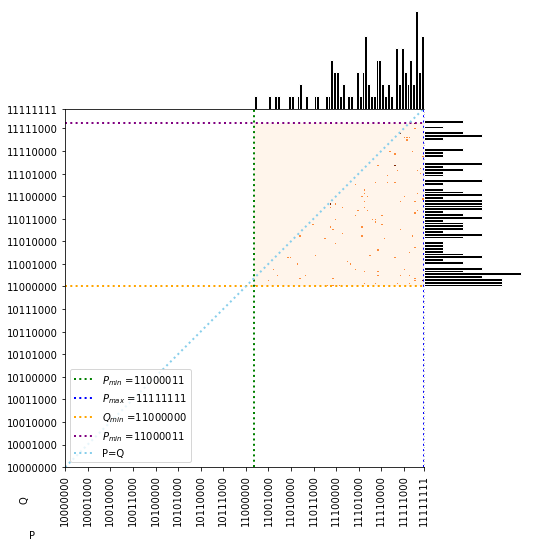

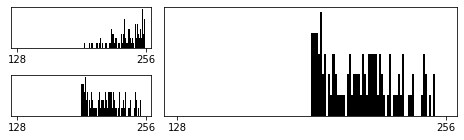

In [363]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

info = {
    'bit_length': 1024,
    'p_byte' : p,
    'q_byte' : q,
    'n_byte' : n
}

def annotate_axes(ax, text, fontsize=18):
    ax.text(0.5, 0.5, text, transform=ax.transAxes,
            ha="center", va="center", fontsize=fontsize, color="darkgrey")

def histogram(info):
    bit_length = info['bit_length']
    p_byte = info['p_byte']
    q_byte = info['q_byte']
    n_byte = info['n_byte']
    record_count = len(p_byte)
    p_min = min(p_byte)
    p_max = max(p_byte)
    q_min = min(q_byte)
    q_max = max(q_byte)
    n_min = min(n_byte)
    n_max = max(n_byte)
    
    
    
    left = 0.1
    width = 0.65
    bottom = 0.1
    height = 0.65
    spacing = 0
    
    
    rect_heat = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]
    
    fig = plt.figure(figsize=(8, 8))
    
    # Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
    # the size of the marginal axes and the main axes in both directions.
    # Also adjust the subplot parameters for a square plot.
    gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0, hspace=0)
    
    ax1 = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax1)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax1)
    
    ax1.hist2d(p_byte, q_byte, bins=(128, 128), cmap=plt.cm.Oranges)
    ax1.set_xlabel("P", loc="left")
    ax1.set_ylabel("Q", loc="bottom")
    
    # Position label for P (xaxis)
    xlbl = ax1.xaxis.get_label()
    x0, y0 = xlbl.get_position()
    ax1.xaxis.set_label_coords(x0-0.1, y0-0.175)
    
    # Position label for Q (yaxis)
    ylbl = ax1.yaxis.get_label()
    x0, y0 = ylbl.get_position()
    ax1.yaxis.set_label_coords(x0-0.1, y0-0.1)
    
    ax1.vlines(x=p_min, ymin=128, ymax=256, colors='green', ls=":", lw=2,  label="$P_{min}$ =" + format(p_min, 'b'))
    ax1.vlines(x=p_max, ymin=128, ymax=256, colors='blue', ls=":", lw=2,   label="$P_{max}$ =" + format(p_max, 'b'))
    ax1.hlines(y=q_min, xmin=128, xmax=256, colors='orange', ls=":", lw=2, label="$Q_{min}$ ="+ format(q_min, 'b'))
    ax1.hlines(y=q_max, xmin=128, xmax=256, colors='purple', ls=":", lw=2, label="$P_{min}$ ="+ format(p_min, 'b'))
    
    ax1.plot(np.arange(128, 256), np.arange(128, 256), 'skyblue', linestyle=':', marker='', lw=2, label="P=Q")
    
    # Show legend
    ax1.legend(loc='lower left')
    
    
    # Set the ticks in binary form
    ticks = list(range(128, 256, 8)) + [255]
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)
    ax1.set_xticklabels(list(map(lambda num: format(num, "b"), ticks)), rotation='vertical')
    ax1.set_yticklabels(list(map(lambda num: format(num, "b"), ticks)))
    
    
    # Add histograms for P and Q
    bins = np.arange(128, 256, 1)
    ax_histx.hist(p_byte, bins=bins,color = "black", ec="white")
    ax_histy.hist(q_byte, bins=bins, orientation='horizontal',color="black", ec ="white")
    
    # Turn off their axes
    ax_histx.set_axis_off()
    ax_histy.set_axis_off()
    
    fig = plt.figure(figsize=(8,2))
    gs = fig.add_gridspec(5, 6)

    p_dens = fig.add_subplot(gs[0:2, 0:2])
    q_dens = fig.add_subplot(gs[3:, 0:2])
    n_dens = fig.add_subplot(gs[:, 2:8])
    
    
    p_dens.hist(p_byte, bins=bins, color = "black", histtype='stepfilled')
    q_dens.hist(q_byte, bins=bins, color="black", histtype='stepfilled')
    n_dens.hist(q_byte, bins=bins, color="black", histtype='stepfilled')
    
    p_dens.set_xticks([128,256])
    p_dens.set_yticks([])
    
    q_dens.set_xticks([128,256])
    q_dens.set_yticks([])
    
    n_dens.set_xticks([128,256])
    n_dens.set_yticks([])
    
    plt.show()

histogram(info)